In [1]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.datasets
import sklearn.decomposition

import sys
sys.path.append('../')
import paradime.routines
import paradime.utils
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.dr

In [2]:
from cerberus import Validator

In [29]:
import json
with open("../paradime/schema.json") as f:
    v = Validator(schema=json.load(f))

In [46]:
spec = """
dataset:
  - name: main
    data: []
  - name: pca
    data func: pca
    keys:
      [['data', 'main']]
relations:
  - name: p
    level: global
    reltype: neighbor
    options:
      metric: euclidean
    transforms:
      - tftype: perplexity
        options:
          perplexity: 100
      - tftype: symmetrize
      - tftype: normalize
  - name: q
    level: batch
    reltype: pairwise
    options:
      metric: euclidean
    transforms:
      - tftype: t-dist
        options:
          alpha: 1.
      - tftype: normalize
losses:
  - name: init
    losstype: position
    func: mse
    keys:
      data: [main, pca]
  - name: emb
    losstype: relation
    func: kl div
    keys:
      rels: [p, q]
training phases:
  # pca initialization
  - loss:
      components: [init]
    sampling:
      samplingtype: item
  # main embedding
  - loss:
      components: [emb]
    sampling:
      samplingtype: item
"""

In [47]:
import yaml
foo = yaml.load(spec, yaml.Loader)

In [48]:
v.validate(foo)

True

In [49]:
v.errors

{}

In [14]:
import yaml

if "foo" not in yaml.load(spec, Loader=yaml.Loader):
    print("fail")

fail


In [2]:
foo = paradime.dr.Dataset({
    'data': torch.tensor([[1., 2., 3.,], [4., 5., 6.]]),
    'other': torch.tensor([10., 20]),
    'derived': paradime.dr.DerivedDatasetEntry(
        lambda x: x**2,
        [('data', 'other')]
    )
})

In [3]:
bar = paradime.dr.ParametricDR(dataset=foo)
bar.compute_derived_data()

RuntimeError: dictionary changed size during iteration

In [7]:
bar.dataset

Dataset(
  data={'data': tensor([[1., 2., 3.],
          [4., 5., 6.]]), 'other': tensor([10., 20.]), 'indices': tensor([0, 1]), 'derived': tensor([100., 400.])},
  _derived_entries={'derived': <paradime.dr.DerivedDatasetEntry object at 0x000001888E4381C0>},
)

In [5]:
foo = torch.rand((10,10))
foo.fill_diagonal_(0.)
paradime.loss.kullback_leibler_div(foo, foo**2)

tensor(2.0741)

In [86]:
import scipy.stats

In [125]:
num_classes = 7
num_dims = 20
num_items_per_class = 50
centroids = np.random.randint(0, 5, (num_classes, num_dims))
dists = [ scipy.stats.multivariate_normal(c, cov=5) for c in centroids ]
data = np.concatenate([ d.rvs(num_items_per_class) for d in dists ])
labels = np.repeat(np.arange(num_classes), num_items_per_class)

num_line_items = 11
line = np.linspace(centroids[0], centroids[1], num_line_items)
data = np.concatenate((data, line))
labels = np.concatenate((labels, np.repeat(num_classes, num_line_items)))

In [126]:
tsne = sklearn.manifold.TSNE(perplexity=30)
emb = tsne.fit_transform(data)

c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

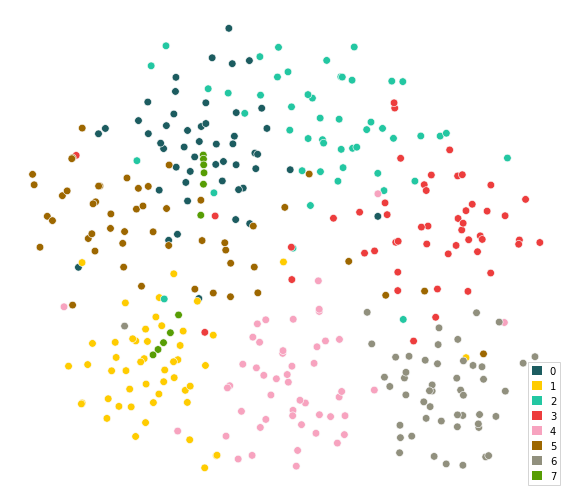

In [127]:
paradime.utils.plotting.scatterplot(emb, labels)

In [128]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        self.m = torch.nn.Linear(in_dim, out_dim)

    def embed(self, x):
        return self.forward(x)

    def forward(self, x):
        return self.m(x)

In [129]:
ltsne = paradime.routines.ParametricTSNE(
    perplexity=30,
    dataset=torch.tensor(data, dtype=torch.float),
    model=LinearModel(num_dims,2),
    batch_size=100,
    epochs=50,
    learning_rate=0.01,
    init_batch_size=100,
    init_epochs=10,
    use_cuda=True,
    verbose=True,
)
# ltsne.global_relations = {
#     'rel': paradime.relations.NeighborBasedPDist(
#         transform=[
#             paradime.transforms.PerplexityBasedRescale(
#                 perplexity=30,
#                 bracket=[0.0001, 100.]),
#             paradime.transforms.Symmetrize(),
#             paradime.transforms.Normalize(),
#         ],
#     )
# }
ltsne.train()

2022-08-19 22:07:20,062: Registering dataset.
2022-08-19 22:07:20,076: Adding entry 'pca' to dataset.
2022-08-19 22:07:20,077: Computing global relations 'rel'.
2022-08-19 22:07:20,077: Indexing nearest neighbors.
2022-08-19 22:07:20,172: Calculating probabilities.
2022-08-19 22:07:20,195: Beginning training phase 'pca_init'.
2022-08-19 22:07:20,208: Loss after epoch 0: 56.3539981842041
2022-08-19 22:07:20,272: Loss after epoch 5: 13.035952091217041
2022-08-19 22:07:20,311: Beginning training phase 'embedding'.
2022-08-19 22:07:20,422: Loss after epoch 0: 0.08533037453889847
2022-08-19 22:07:20,485: Loss after epoch 5: 0.08061662502586842
2022-08-19 22:07:20,549: Loss after epoch 10: 0.07617056556046009
2022-08-19 22:07:20,612: Loss after epoch 15: 0.07460557296872139
2022-08-19 22:07:20,679: Loss after epoch 20: 0.07639950234442949
2022-08-19 22:07:20,745: Loss after epoch 25: 0.07686828542500734
2022-08-19 22:07:20,811: Loss after epoch 30: 0.07738756388425827
2022-08-19 22:07:20,873

<AxesSubplot:>

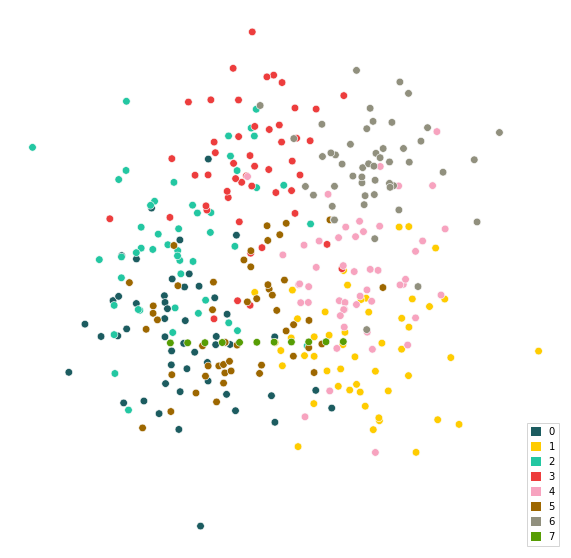

In [130]:
paradime.utils.plotting.scatterplot(ltsne.apply(data), labels)

In [20]:
mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
mnist_labels = mnist.targets
num_items = 5000

In [3]:
num_pts = 5000
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:num_pts][np.argsort(mnist.targets[:num_pts])]
testtargets = np.sort(mnist.targets[:num_pts])

In [27]:
# paradime.utils.seed_all(42)
foo = paradime.routines.ParametricTSNE(
    perplexity=100,
    dataset=mnist_data[:num_items],
    init_epochs=10,
    epochs=40,
    init_batch_size=500,
    batch_size=500,
    init_learning_rate=0.01,
    learning_rate=0.01,
    use_cuda=True,
    verbose=True
)
foo.train()

2022-08-09 14:45:15,394: Registering dataset.
2022-08-09 14:45:15,540: Adding entry 'pca' to dataset.
2022-08-09 14:45:15,541: Computing global relations 'rel'.
2022-08-09 14:45:15,542: Indexing nearest neighbors.
2022-08-09 14:45:23,069: Calculating probabilities.
2022-08-09 14:45:23,531: Beginning training phase 'pca_init'.
2022-08-09 14:45:23,631: Loss after epoch 0: 24.61532735824585
2022-08-09 14:45:24,075: Loss after epoch 5: 0.2595231793820858
2022-08-09 14:45:24,435: Beginning training phase 'embedding'.
2022-08-09 14:45:24,964: Loss after epoch 0: 24.20934510231018
2022-08-09 14:45:27,767: Loss after epoch 5: 19.14391851425171
2022-08-09 14:45:30,644: Loss after epoch 10: 17.37018883228302
2022-08-09 14:45:33,650: Loss after epoch 15: 16.637165069580078
2022-08-09 14:45:36,544: Loss after epoch 20: 16.339418530464172
2022-08-09 14:45:39,478: Loss after epoch 25: 15.957655549049377
2022-08-09 14:45:42,413: Loss after epoch 30: 15.788440346717834
2022-08-09 14:45:45,380: Loss af

<AxesSubplot:>

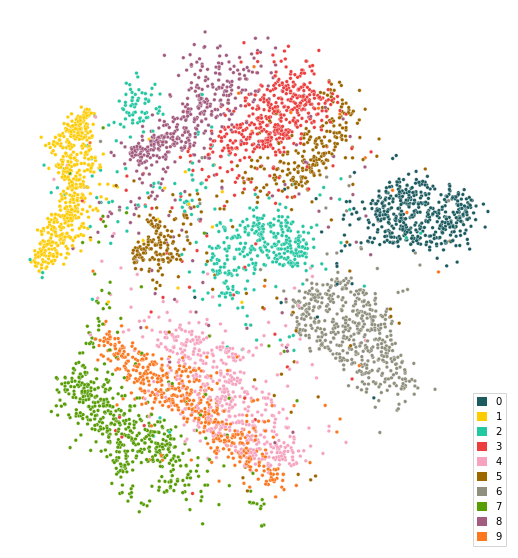

In [32]:
paradime.utils.scatterplot(
    foo.apply(mnist_data[:num_items]),
    mnist_labels[:num_items]
)

<AxesSubplot:>

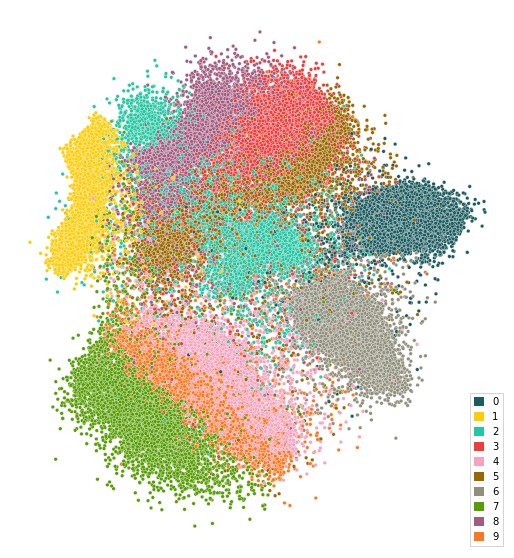

In [30]:
paradime.utils.scatterplot(
    foo.apply(mnist_data),
    mnist_labels
)

In [23]:
tsne = paradime.dr.ParametricDR(
    global_relations=paradime.relations.NeighborBasedPDist(
        transform=[
            paradime.transforms.PerplexityBasedRescale(perplexity=100),
            paradime.transforms.Symmetrize(),
            paradime.transforms.Normalize(),
            ]
        ),
    batch_relations=paradime.relations.DifferentiablePDist(
            transform=[
                paradime.transforms.StudentTTransform(alpha=1.),
                paradime.transforms.Normalize(),
                paradime.transforms.ToSquareTensor(),
            ]
        ),
    in_dim=28*28,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=mnist_data[:num_items],
    use_cuda=True,
    verbose=True,
)
tsne.add_to_dataset({
    'pca': torch.tensor(sklearn.decomposition.PCA(n_components=2).fit_transform(
        testdata), dtype=torch.float)
})
tsne.add_training_phase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key='pca'),
    batch_size=500,
    n_epochs=10,
    learning_rate=0.01,
)
tsne.add_training_phase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    n_epochs=40,
    learning_rate=0.02,
    report_interval=2,
)

2022-08-09 14:39:06,269: Registering dataset.
2022-08-09 14:39:06,399: Adding entry 'pca' to dataset.


In [24]:
with torch.autograd.detect_anomaly():
    tsne.train()

C:\Users\Andreas\AppData\Local\Temp\ipykernel_13104\1834518232.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
2022-08-09 14:39:08,337: Computing global relations 'rel'.
2022-08-09 14:39:08,339: Indexing nearest neighbors.
2022-08-09 14:39:16,052: Calculating probabilities.
2022-08-09 14:39:16,523: Beginning training phase 'pca_init'.
2022-08-09 14:39:16,746: Loss after epoch 0: 47.2220139503479
2022-08-09 14:39:17,864: Loss after epoch 5: 44.062530517578125
2022-08-09 14:39:18,730: Beginning training phase 'embedding'.
2022-08-09 14:39:19,779: Loss after epoch 0: 28.62554430961609
2022-08-09 14:39:21,988: Loss after epoch 2: 23.56133270263672
2022-08-09 14:39:24,157: Loss after epoch 4: 21.260617971420288
2022-08-09 14:39:26,376: Loss after epoch 6: 20.025802969932556
2022-08-09 14:39:28,563: Loss after epoch 8: 19.227874279022217
2022-08-09 14:39:30,774: Loss a

<AxesSubplot:>

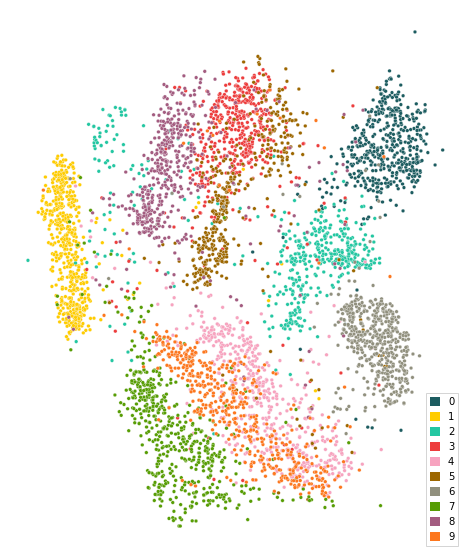

In [19]:
paradime.utils.scatterplot(tsne.apply(testdata), labels=testtargets)

In [69]:
a = tsne.global_relations['rel'].compute_relations(testdata)

2022-08-08 14:13:30,390: Indexing nearest neighbors.
2022-08-08 14:13:38,376: Calculating probabilities.


In [72]:
mine = a.data.toarray()

In [76]:
from openTSNE.affinity import PerplexityBasedNN
p = PerplexityBasedNN(data=testdata, perplexity=100)

In [73]:
his = p.P.toarray()

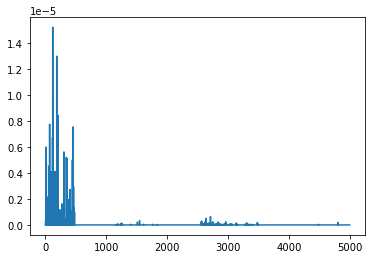

In [88]:
plt.plot(mine[4]/mine.sum())

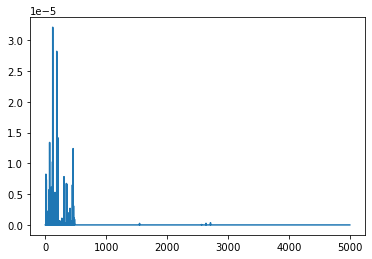

In [87]:
plt.plot(his[4])

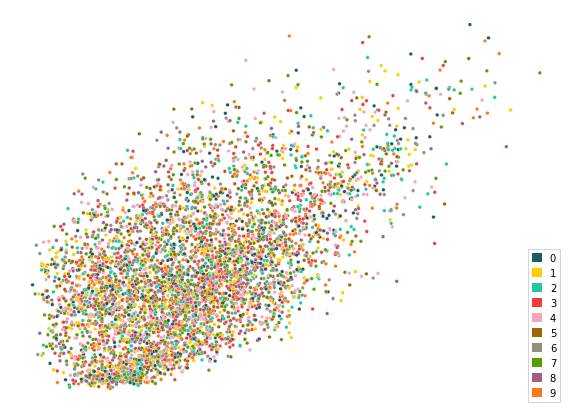

In [30]:
paradime.utils.scatterplot(tsne.apply(testdata), mnist.targets[:num_pts]);

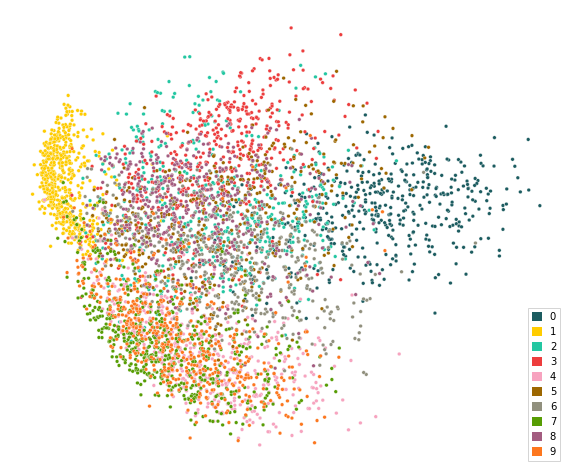

In [21]:
paradime.utils.scatterplot(
    tsne.dataset.data['pca'],
    testtargets,
);

In [22]:
dr = paradime.routines.ParametricUMAP(
    n_neighbors=100,
    dataset=testdata,
    verbose=True,
    use_cuda=True,
)
dr.train()

2022-08-08 13:03:56,740: Registering dataset.
2022-08-08 13:03:56,753: Computing global relations 'rel'.
2022-08-08 13:03:56,754: Indexing nearest neighbors.
2022-08-08 13:04:00,028: Calculating probabilities.
2022-08-08 13:04:04,086: Adding entry 'spectral' to dataset.
2022-08-08 13:04:04,087: Beginning training phase 'spectral_init'.
2022-08-08 13:04:04,320: Loss after epoch 0: 445.443996489048
2022-08-08 13:04:05,061: Beginning training phase 'embedding'.
2022-08-08 13:04:05,856: Loss after epoch 0: 25109.464076042175
2022-08-08 13:04:09,806: Loss after epoch 5: 1509.1316299438477
2022-08-08 13:04:13,741: Loss after epoch 10: 1507.1820831298828
2022-08-08 13:04:17,703: Loss after epoch 15: 1355.9247574806213
2022-08-08 13:04:21,682: Loss after epoch 20: 1535.792890548706
2022-08-08 13:04:25,680: Loss after epoch 25: 1437.8193340301514


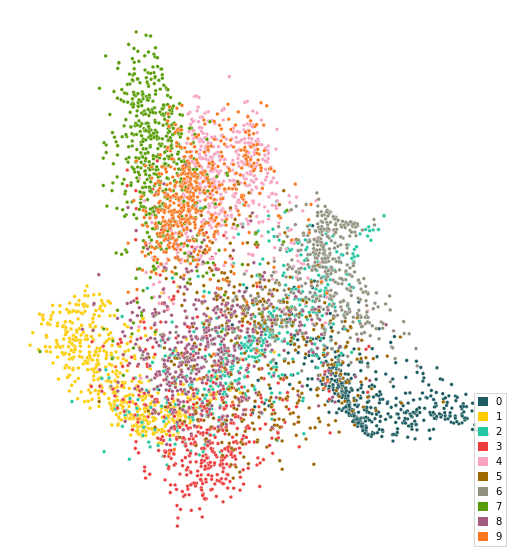

In [24]:
paradime.utils.scatterplot(
    dr.apply(testdata),
    testtargets
);

In [112]:
class EmbeddingClassificationHybrid(prdm.models.Model):

    def __init__(self,
        in_dim: int,
        class_dim: int,
        emb_dim: int,
        hidden_dims: list[int]
    ):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        self.class_dim = class_dim
        
        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.class_layer = torch.nn.Linear(cur_dim, class_dim)
        self.emb_layer = torch.nn.Linear(cur_dim, emb_dim)

    def common_forward(self, x):
        for layer in self.layers:
            # x = torch.sigmoid(layer(x))
            x = torch.nn.Softplus()(layer(x))
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        x = torch.nn.Softmax(dim=1)(x)
        return x

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def forward(self, x):
        return self.embed(x)    

In [118]:
mymodel = EmbeddingClassificationHybrid(28*28, 10, 2, [50, 50])

foo = prdm.ParametricDR(
    model=mymodel,
    dataset={
        'data': testdata,
        'labels': testtargets,
    },
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=[
            prdm.transforms.PerplexityBasedRescale(
                perplexity=50
            ),
            prdm.transforms.Symmetrize()
        ]
    ),
    batch_relations=prdm.relations.DifferentiablePDist(
        transform=[
            prdm.transforms.StudentTTransform(alpha=1.),
            prdm.transforms.Normalize(),
            prdm.transforms.ToSquareTensor(),
        ]
    ),
    use_cuda=True,
    verbose=True,
)
foo.add_training_phase(prdm.TrainingPhase(
    name='main',
    n_epochs=30,
    batch_size=500,
    loss=prdm.loss.CompoundLoss([
        prdm.loss.RelationLoss(
            loss_function=prdm.loss.kullback_leibler_div
        ),
        prdm.loss.ClassificationLoss()
        ],
        weights=[1., 190.],
    )
))
foo.train()

2022-08-03 16:04:23.1: Registering dataset.
2022-08-03 16:04:23.1: Computing global relations 'rel'.
2022-08-03 16:04:23.1: Indexing nearest neighbors.
2022-08-03 16:04:27.7: Calculating probabilities.
2022-08-03 16:04:28.1: Beginning training phase 'main'.
2022-08-03 16:04:28.6: Loss after epoch 0: 7834.165466308594
2022-08-03 16:04:31.3: Loss after epoch 5: 6434.125244140625
2022-08-03 16:04:33.8: Loss after epoch 10: 6100.394226074219
2022-08-03 16:04:36.5: Loss after epoch 15: 6201.397705078125
2022-08-03 16:04:39.2: Loss after epoch 20: 6040.8719482421875
2022-08-03 16:04:41.8: Loss after epoch 25: 5873.6700439453125


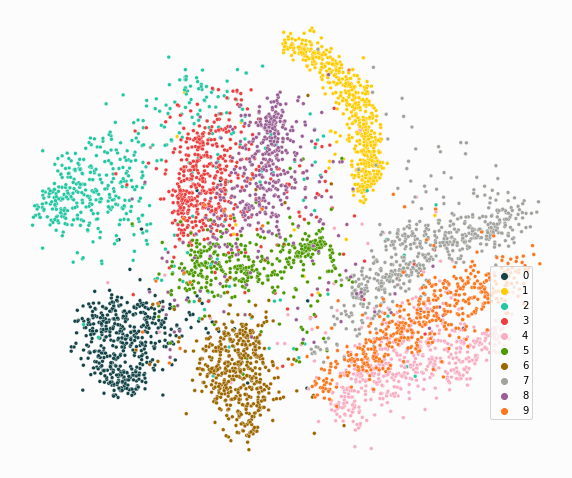

In [119]:
emb = foo.embed(testdata.cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

In [120]:
(foo.model.classify(testdata.cuda()).detach().cpu().argmax(dim=1).numpy() == testtargets).sum()

4418

In [122]:
a,b = [ lo.history for lo in foo.training_phases[0].loss.losses ]

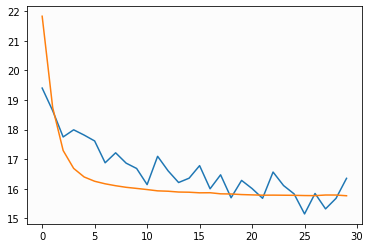

In [126]:
plt.plot(np.array(a)/190.)
plt.plot(b)

In [47]:
prdm.utils.seed_all(42)

dr = prdm.routines.ParametricTSNE(
    perplexity=100,
    dataset=testdata,
)
dr.train()

In [33]:
import seaborn as sns

In [44]:
def plot_result(data, labels):
    palette = sns.color_palette(prdm.utils.get_color_palette().values())
    fig = plt.figure(figsize=(10,10))
    sp = sns.scatterplot(
        x=data[:,0],
        y=data[:,1],
        hue=labels,
        s=14.,
        alpha=1.,
        edgecolor="white",
        palette=palette
    )
    sp.tick_params(bottom=False, left=False)
    sp.set(xticklabels=[],yticklabels=[], aspect=1.)
    sns.despine(top=True, left=True, bottom=True, right=True)
    sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

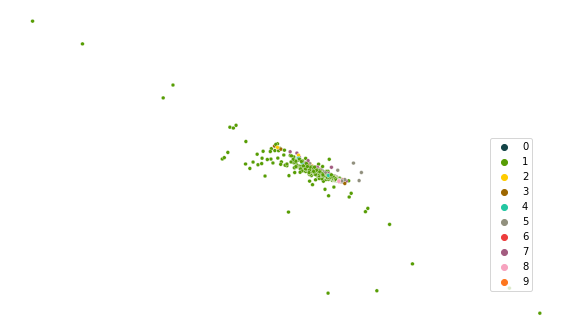

In [48]:
plot_result(dr(mnist.data.reshape(-1, 28*28) / 255.).detach(), mnist.targets)

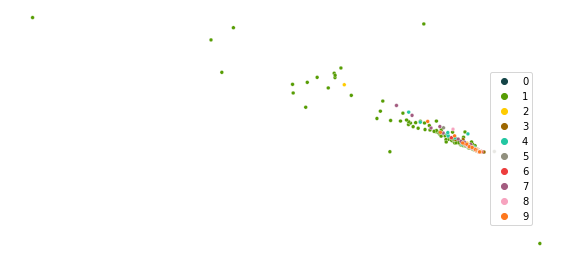

In [49]:
plot_result(dr(testdata).detach(), testtargets)

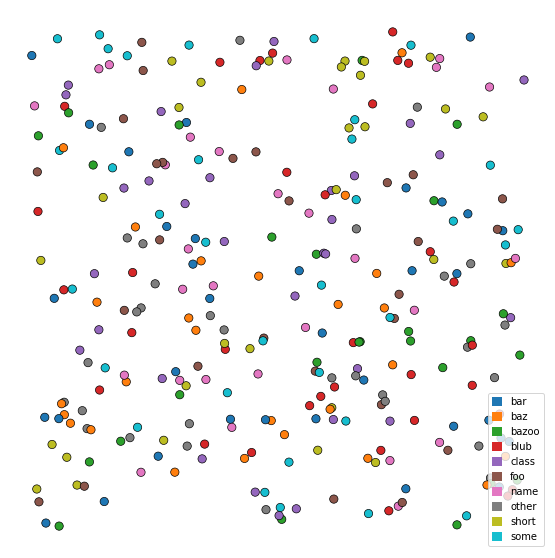

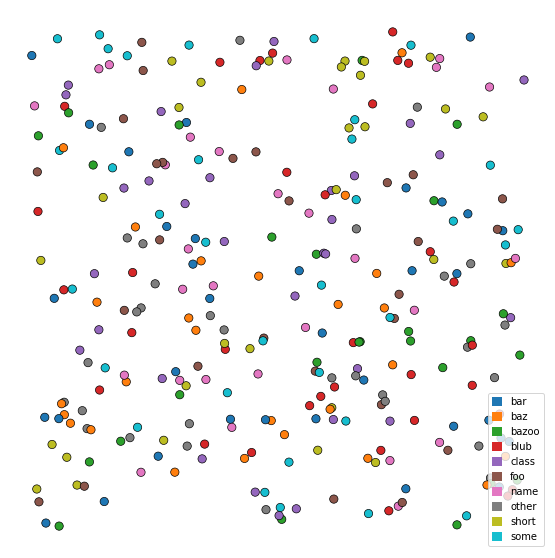

In [146]:
scatterplot(np.random.random((300,2)),labels=np.random.choice(dummy_classes,300),
colormap=list(matplotlib.colors.TABLEAU_COLORS.values()),edgecolor='black')